In [1]:
import datetime
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math
import numpy as np
import time
from quandl import QuandlError
plt.style.use('alex')

In [46]:
colors = [prop['color'] for prop in plt.rcParams['axes.prop_cycle']]
colors

['#d93f37',
 '#4937d6',
 '#37d65c',
 '#d99037',
 '#d941a6',
 '#41dba8',
 '#a14f23',
 'gray',
 '#ff7396',
 '#fff047']

In [3]:
syms = pd.read_csv("C:/Users/awright/Desktop/January 2018/Other/trading/Asset listings/StockSymbols2000.csv", encoding = "ISO-8859-1")

sym = 'GWA_LTC'
datestart = '1-1-2018'
dateend = '2-2-2018'


In [18]:
class Market:
    ''' The Market class has two primary roles: to pull data from the Quandl API, and to store that data in a
    structured dataframe, self.History.  The one required parameter is exchange -- which will correspond to one
    of the available exchange codes listed below.  User can also pass a datestart parameter, which specifies from
    which date onwards the request for data will be made. The passed exchange code will be formatted correctly for the
    Quandl API and passed for a request.  
    
    The file parameter should be the location of the file that stores your market data in .csv format, and the data 
    should be structured in the format of the class self.History pandas DataFrame. In the event that a file
    parameter is passed, the initialization of the class will identify the latest date in the dataframe, and set
    datestart to this date.
    
    In all cases the class pulls in data up to the current date.
    
    Market class has access to the following exchanges via the Quandl API:
    
    Wiki stock Prices (High Volumne)	WIKIP2000
     Wiki stock Prices (Lower Volumne)	WIKIP_over2000
    BraveNewCoin	BNC
    London Metal Exchange	LME
    Chicago Mercantile Exchange	CME
    Intercontinental Exchange Futures	ICE
    London Stock Exchange	LSE
    Wiki Commodity Price	COM
    Hong Kong Exchange	HKEX
    Warsaw Stock Exchange	WSE
    Global Petroleum Prices (Gasoline)	GPPG
    Global Petroleum Prices (Diesel)	GPPD
    London Platinum and Palladium Market	LPPM
    LIFFE Futures Data	LIFFE
    Eurex Futures	EUREX
    Johnson Matthey	JOHNMATT
'''
    
    def __init__(self,
                 Market_file = None,
                 exclude_file = None,
                 mavg_df_file = None,
                 acf_df_file = None,
                 dir_file = "C:/Users/awright/Desktop/January 2018/Other/trading/Asset listings/MarketandListingCodes.csv"
                 ):
        
        
        quandl.ApiConfig.api_key = 'Npr_WVEspvDGSfRd9Dt_'          
        self.colors = [prop['color'] for prop in plt.rcParams['axes.prop_cycle']]
        
        if exclude_file:
            self.excludes = pd.read_csv(exclude_file, header=None).iloc[:,0].values
        else:
            self.excludes = None
            
        if mavg_df_file:
            self.mavg_df = pd.read_csv(mavg_df_file, 
                                       index_col = 0,
                                       encoding = "ISO-8859-1", dtype = {'Date':str}, parse_dates=['Date'])
        else:
            self.mavg_df = None
            
        if acf_df_file:
            self.acf_df = pd.read_csv(acf_df_file)
        else:
            self.acf_df = None
            
        if dir_file:
            self.Dir = pd.read_csv(dir_file)
        else:
            self.Dir = None
        
        if Market_file:
        ## Append an existing History from the latest date to today ##

            self.History = pd.read_csv(Market_file, index_col = 0, encoding = "ISO-8859-1", dtype = {'Symbol':object,
                                                                                    'Description':object,
                                                                                    'Date': str,
                                                                                    'Open':'float64',
                                                                                    'Close':'float64',
                                                                                    'High':'float64',
                                                                                    'Low':'float64',
                                                                                    'Volume':'float64',
                                                                                    'DailyPctChg':'float64'},
                                                                                     parse_dates=['Date'])  
            self.dateStart = max(self.History.Date)
        
        else:

            self.History = pd.DataFrame([],columns = ['Symbol',
                                                      'Description',
                                                      'Date',
                                                      'Open',
                                                      'Close',
                                                      'High',
                                                      'Low',
                                                      'Volume',
                                                      'DailyPctChg']).astype({'Symbol':object,
                                                                         'Description':object,
                                                                         'Date': datetime.date,
                                                                         'Open':'float64',
                                                                         'Close':'float64',
                                                                         'High':'float64',
                                                                         'Low':'float64',
                                                                         'Volume':int,
                                                                         'DailyPctChg':'float64'})
    
        self.symbols = self.History.Symbol.unique()
    
    def getHistory(self,
                  exchange,
                  period = 'daily',
                  datestart = (str((datetime.datetime.now().date() + datetime.timedelta(days  =-1)).year) 
                      + '-' + str((datetime.datetime.now().date() + datetime.timedelta(days  =-1)).month) + '-' 
                      + str((datetime.datetime.now().date() + datetime.timedelta(days  =-1)).day)),
                  dateend = (str((datetime.datetime.now().date().year))
                      + '-' + str((datetime.datetime.now().date().month))
                      + '-' + str((datetime.datetime.now().date().day)))):
        
        self.dateStart = datestart
        self.dateEnd = dateend
        
        if len(self.History) != 0:
            self.dateStart = max(self.History.Date) + datetime.timedelta(days=1)

        if exchange == 'WIKIP2000':
            syms = pd.read_csv("C:/Users/awright/Desktop/January 2018/Other/trading/Asset listings/StockSymbols2000.csv"
                              , encoding = "ISO-8859-1")
            
            for i in range(len(syms)):  
                sym = syms['Symbol'][i]
                description = syms['Description'][i]
                try:
                    code = 'WIKI/' + sym
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
                    assetHistory['Symbol'] = sym
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Open','High','Low','Close', 'Volume','Symbol','Description']

                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'WIKIP_over2000':
            syms = pd.read_csv("C:/Users/awright/Desktop/January 2018/Other/trading/Asset listings/StockSymbols_over2000.csv"
                              , encoding = "ISO-8859-1")

            for i in range(len(syms)):  
                sym = syms['Symbol'][i]
                description = syms['Description'][i]
                try:
                    code = 'WIKI/' + sym
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
                    assetHistory['Symbol'] = sym
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Open','High','Low','Close', 'Volume','Symbol','Description']

                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue


        elif exchange == 'BNC3':
            for row in self.Dir[self.Dir['Exchange'] == exchange].index.tolist():
                try:
                    code = self.Dir.loc[row,'Listing']
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Open','High','Low','Close', 'Volume']]
                    assetHistory['Symbol'] = self.Dir.loc[row,'Symbol']
                    assetHistory['Description'] = self.Dir.loc[row,'Description']

                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(self.Dir.loc[row,'Description'],self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(self.Dir.loc[row,'Description']))
                    continue

        elif exchange == 'LME':
            for row in self.Dir[self.Dir['Exchange'] == exchange].index.tolist():
                code = self.Dir.loc[row,'Listing']
                try:
                    self.History = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    print('London Metal Exchange Data Loaded for dates from {} to {} '.format(code,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(code))
                    continue

        elif exchange == 'CME':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'CME'].loc[:,'Listing'].values.tolist():
                if l[-4:] in ['2017','2018','2019','2020','2021']:
                    listings.append(l)
                    if len(listings) > 2000:
                        listings = listings[:2000]

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Settle']]
                    assetHistory['Symbol'] = code[4:]
                    assetHisory['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue           

        elif exchange == 'ICE':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'ICE'].loc[:,'Listing'].values.tolist():
                if l[-4:] in ['2017','2018','2019','2020','2021']:
                    listings.append(l)
                    if len(listings) > 2000:
                        listings = listings[:2000]

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Settle']]
                    assetHistory['Symbol'] = code[4:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol', 'Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'LSE':
            syms = pd.read_csv("C:/Users/awright/Desktop/January 2018/Other/trading/Asset listings/LSE_Subset.csv")
            for i in rang(len(syms)):
                sym = syms['Symbol'][i]
                description = syms['Description'][i]
                try:
                    code = 'LSE/' + sym
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','High','Low','Last Close', 'Volume']]
                    assetHistory['Symbol'] = sym
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','High','Low','Close', 'Volume','Symbol','Description']

                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'COM':

            for row in self.Dir[self.Dir['Exchange'] == exchange].index.tolist():
                code = self.Dir.loc[row,'Listing']
                description = self.Dir.loc[row,'Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Value']]
                    assetHistory['Symbol'] = self.Dir.loc[row,'Symbol']
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'HKEX':
            Symbols = []
            Codes = []
            for i in range(1,2001):
                digits = len(str(i))
                Symbol = '00000'
                Symbol = Symbol[:5-digits] + str(i)
                Code = 'HKEX/' + Symbol
                Symbols.append(Symbol)
                Codes.append(Code)

            for i in range(len(Codes)):
                description = self.Dir[self.Dir['Listing'] == Codes[i]]['Description']
                try:
                    assetHistory = quandl.get(Codes[i], start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Nominal Price','High','Low','Share Volume (000)']]
                    assetHistory['Symbol'] = Symbols[i]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Close','High','Low','Volume','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(Description,self.dateStart,self.dateEnd))

                except (QuandlError, KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'WSE':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'WSE'].loc[:,'Listing'].values.tolist():
                    listings.append(l)

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Open','High','Low','Close','Volume']]
                    assetHistory['Symbol'] = code[4:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Open','High','Low','Close','Volume','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'GPPG':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'GPP'].loc[:,'Listing'].values.tolist():
                    listings.append(l)

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Gasoline Price']]
                    assetHistory['Symbol'] = code[4:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'GPPD':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'GPP'].loc[:,'Listing'].values.tolist():
                    listings.append(l)
            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Diesel Price']]
                    assetHistory['Symbol'] = code[4:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'LPPM':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'LPPM'].loc[:,'Listing'].values.tolist():
                    listings.append(l)

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','USD PM']]
                    assetHistory['Symbol'] = code[5:]
                    assetHistry['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'LIFFE':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'LIFFE'].loc[:,'Listing'].values.tolist():
                if l[-4:] in ['2017','2018','2019','2020','2021','2022','2023']:
                    listings.append(l)

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Open','High','Low','Settle','Volume']]
                    assetHistory['Symbol'] = code[6:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Open','High','Low','Close','Volume','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'EUREX':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'EUREX'].loc[:,'Listing'].values.tolist():
                if l[-4:] in ['2017','2018','2019','2020','2021','2022','2023']:
                    listings.append(l)

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','Open','High','Low','Settle','Volume']]
                    assetHistory['Symbol'] = code[6:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Open','High','Low','Close','Volume','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue

        elif exchange == 'JOHNMATT':
            listings = []
            for l in self.Dir[self.Dir['Exchange'] == 'JOHNMATT'].loc[:,'Listing'].values.tolist():
                    listings.append(l)

            for code in listings:
                description = self.Dir[self.Dir['Listing'] == code]['Description']
                try:
                    assetHistory = quandl.get(code, start_date=self.dateStart, end_date=self.dateEnd,collapse = period).reset_index()
                    assetHistory = assetHistory[['Date','New York 9:30']]
                    assetHistory['Symbol'] = code[9:]
                    assetHistory['Description'] = description
                    assetHistory.columns = ['Date','Close','Symbol','Description']
                    self.History = pd.concat([self.History,assetHistory], ignore_index=True)
                    print('{} data acquired for dates from {} to {}'.format(description,self.dateStart,self.dateEnd))

                except (KeyError, NameError):
                    print('{} data FAILED TO LOAD'.format(description))
                    continue
                    
        self.History = self.History[['Symbol','Description','Date','Volume','Open','Low','High','Close']]
        self.History['DailyPctChg'] = (self.History['Close'] / (self.History.groupby('Symbol')['Close'].shift(1))) - 1
        
   

 ################################# Plotting Methods #################################

    def tsPlotTogether(self,
                 symbols,
                  metric = 'price',
                 datestart = (str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).year) 
                      + '-' + str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).month) + '-' 
                      + str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).day)),
                  dateend = (str((datetime.datetime.now().date().year))
                      + '-' + str((datetime.datetime.now().date().month))
                      + '-' + str((datetime.datetime.now().date().day)))):
        ''' available metrics: price, maxnorm, pctchg'''
        

        dates = self.History['Date'][(self.History['Symbol'] == symbols[0]) 
                             &(self.History['Date'] >= datestart)
                             & (self.History['Date'] <= dateend)]
        
        fig, ax = plt.subplots(figsize=(16,8))
                               
        if metric == 'price':

            for i in range(len(symbols)):

                sym = symbols[i]
                prices = self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Close.values
                
                ax.set_title('Time Series from {} to {} \n Metric = {}'.format(datestart,dateend,metric), fontsize = 16)
                ax.plot(dates,prices, label = sym)

            plt.legend()
            plt.show()
            
        if metric == 'maxnorm':

            for i in range(len(symbols)):

                sym = symbols[i]
                prices = (self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Close.values 
                          / max(self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Close))
                          
                ax.set_title('Time Series from {} to {} \n Metric = {}'.format(datestart,dateend,metric), fontsize = 16)
                ax.plot(dates,prices, label = sym)

            plt.legend()
            plt.show()
            
        if metric == 'pctchg':

            for i in range(len(symbols)):

                sym = symbols[i]
                pctChgs = self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].DailyPctChg.values
                
                ax.set_title('Time Series from {} to {} \n Metric = {}'.format(datestart,dateend,metric), fontsize = 16)
                ax.plot(dates,pctChgs, label = sym)

            plt.legend()
            plt.show()
            
    def tsPlotAlone(self,
                 symbols,
                  metric = 'price',
                 datestart = (str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).year) 
                      + '-' + str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).month) + '-' 
                      + str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).day)),
                  dateend = (str((datetime.datetime.now().date().year))
                      + '-' + str((datetime.datetime.now().date().month))
                      + '-' + str((datetime.datetime.now().date().day)))):
        ''' available metrics: price, pctchg'''
        


        
        ncols = 1
        nrows = max([2,len(symbols)])
        rows = len(symbols)
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols,figsize=(16,8*nrows))
        
        if metric == 'price':

            for i in range(rows):
                    sym = symbols[i]

                    dates = self.History['Date'][(self.History['Symbol'] == sym) 
                     &(self.History['Date'] >= datestart)
                     & (self.History['Date'] <= dateend)]

                    prices = self.History[(self.History['Symbol'] == sym)
                               & (self.History['Date'] >= datestart)
                               & (self.History['Date'] <= dateend)].Close.values
                    
                    volumes = self.History[(self.History['Symbol'] == sym)
                               & (self.History['Date'] >= datestart)
                               & (self.History['Date'] <= dateend)].Volume.values
                    
                    scale =  4 * ( max(self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Volume)
                            / max(self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Close))
                    
                    scaled_volumes = volumes / scale


                    ax[i].plot(dates,prices)
                    ax[i].bar(dates.tolist(),scaled_volumes, alpha = 0.7)
                    #ax[i].grid(which='both')
                    ax[i].set_title('{} from {} to {}\n Metric = {}'.format(sym,datestart,dateend,metric), fontsize=16)
                    

            plt.show()
            
        if metric == 'pctchg':

            for i in range(rows):
                    sym = symbols[i]

                    dates = self.History['Date'][(self.History['Symbol'] == sym) 
                     &(self.History['Date'] >= datestart)
                     & (self.History['Date'] <= dateend)]

                    pctChgs = self.History[(self.History['Symbol'] == sym)
                               & (self.History['Date'] >= datestart)
                               & (self.History['Date'] <= dateend)].DailyPctChg.values
                    
                    volumes = self.History[(self.History['Symbol'] == sym)
                               & (self.History['Date'] >= datestart)
                               & (self.History['Date'] <= dateend)].Volume.values
                    
                    scale =  4 * ( max(self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Volume)
                            / max(self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].DailyPctChg))
                    
                    scaled_volumes = volumes / scale


                    ax[i].plot(dates,pctChgs)
                    ax[i].bar(dates.tolist(),scaled_volumes, alpha = 0.7)
                    #ax[i].grid(which='both')
                    ax[i].set_title('{} from {} to {}\n Metric = {}'.format(sym,datestart,dateend,metric), fontsize=16)
                    
            plt.show()
            
         
    def tsPlotMavg(self,
                     symbols = [],
                     windows = [1,5,30],
                      metric = 'price',
                        mavg_df = False,
                     datestart = (str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).year) 
                          + '-' + str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).month) + '-' 
                          + str((datetime.datetime.now().date() + datetime.timedelta(weeks  =-4)).day)),
                      dateend = (str((datetime.datetime.now().date().year))
                          + '-' + str((datetime.datetime.now().date().month))
                          + '-' + str((datetime.datetime.now().date().day)))):
        
        
        
        
        ncols = 1
        nrows = max([2,len(symbols)])
        rows = len(symbols)
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(16,8*nrows))
        
        
        if metric == 'price':
            
            
            
            for i in range(rows):
                sym = symbols[i]
                
                
                dates = self.History['Date'][(self.History['Symbol'] == sym) 
                     &(self.History['Date'] >= datestart)
                     & (self.History['Date'] <= dateend)]

                prices = self.History[(self.History['Symbol'] == sym)
                           & (self.History['Date'] >= datestart)
                           & (self.History['Date'] <= dateend)].Close
                
                
                for window in windows:
                    
                    label = str(window) + ' day mavg'
                    mavgs = prices.rolling(window=window).mean().fillna(0)
                    
                    ax[i].plot(dates,mavgs, label = label)
                    ax[i].set_title('{} Rolling Averages from {} to {}\n Metric = {}'.format(sym,datestart,dateend,metric))
                    ax[i].legend()
                    
                    
            plt.legend()
            plt.show()
            
    
    def plotACF(self, symbols = [], periods = 30, calc_only = False):

        ax = self.acf_df[self.acf_df.Symbol in symbols].plot(kind='bar'
                    , figsize=(16,8)
                    , grid=True
                    , position = 0
                    , title = 'Autocorrelation Corelleogram\n{}'.format(symbols)
                    )

        ax.set_xlabel('Lag (days)')
        ax.set_ylabel('r')
        plt.show()
        
                    
################################# Calculation Methods ####################################        
      
    
    def calcACF(self, periods = 30):
        
        symbols = self.History.Symbol.unique()
        acfs = []
        lags = range(1,periods)
        for sym in symbols:
            sym_pctchg = self.History[self.History['Symbol'] == sym].DailyPctChg
            sym_acf = [sym_pctchg.autocorr(lag = i) for i in lags]
            acfs.append(sym_acf)
            
        self.acf_df = pd.DataFrame(acfs).T
        self.acf_df.columns = symbols
        self.acf_df.index += 1
    
    
    def calcMavg(self, windows = [1,5,30]):
        
        if self.mavg_df is None:
            datestart = min(self.History.Date)
        else:
            datestart = max(self.mavg_df.Date)
            
        dateend = (str((datetime.datetime.now().date().year))
                  + '-' + str((datetime.datetime.now().date().month))
                  + '-' + str((datetime.datetime.now().date().day)))
        

        symbols = self.History.Symbol.unique()

        mavg_dict = {'Date':self.History[(self.History['Date'] >= datestart) 
                                              & (self.History['Date'] <= dateend)].Date.unique()}

        for symbol in symbols:

            for window in windows:

                label = symbol + '-' + str(window) + 'mavg'

                mavg_dict[label] = self.History[(self.History['Symbol'] == symbol) &
                                             (self.History['Date'] >= datestart) 
                                              & (self.History['Date'] <= dateend)].Close.rolling(window=window).mean().values

        self.mavg_df = pd.DataFrame(mavg_dict)




################################# Maintenance Methods ################################

    def saveHistory(self, path):
        '''C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories'''
        self.History.to_csv(path)
        print('History saved\nFile located at {}'.format(path))
        
    def saveAcfDf(self, path):
        
        self.acf_df.to_csv(path)
        print('Autocorrelation DataFrame saved\nFile located at {}'.format(path))
        
    def saveMavgDf(self, path):
        
        self.mavg_df.to_csv(path)
        print('Moving Average DataFrame saved\nFile located at {}'.format(path))
        
    def saveExceptions(self, path):
        
        pd.Series(self.exceptions).to_csv(path)
        print('Exceptions DataFrame saved\nFile located at {}'.format(path))
    
    
    def trimHistory(self,
                    threshold = 10,
                    save_to_file = False,
                    path = None):
        ''' C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_Excludes.csv '''
        
        expected_count = max(self.History.groupby('Symbol').count().Description)
        min_count = expected_count - threshold
        
        self.excludes = self.History.groupby('Symbol').count()[self.History.groupby('Symbol').count().Description < min_count].index.tolist()
        self.History = self.History[~self.History.Symbol.isin(self.excludes)]
        print('The following assets were removed from History:\n{}'.format(str(self.excludes)))
        
        if save_to_file == True:
            pd.Series(self.excludes).to_csv('C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_Excludes.csv'
                           , index = False)
            
            print('Your excludes file has been saved to {}'.format(path))
            
    
    def fillMissingData(self):
        
        pivot = self.History.pivot(index='Date',columns='Symbol',values='Close').isnull()
        pivot = pivot.reset_index()
        unpivot = pd.melt(pivot, id_vars = 'Date', value_vars=pivot.columns[1:])

        missing_data = unpivot[unpivot.value == True]

        subdatas = []

        # For each identified missing date/symbol pair in missing_data, identify the most recent previous existing record and
        # substitute that value in its place.
        for i in range(len(missing_data)):
            breaker = 0
            symbol = missing_data.iloc[i].Symbol
            date = missing_data.iloc[i].Date.to_pydatetime()

            if date.weekday() == 0:
                back = 3
            elif date.weekday() == 6:
                back = 2
            else:
                back = 1

            prevdate = date + datetime.timedelta(days=-back)

            while self.History[(self.History.Date == prevdate) & (self.History.Symbol == symbol)].shape[0] == 0:

                prevdate = prevdate + datetime.timedelta(days=-1)

                if prevdate <= min(self.History.Date):

                    self.History = self.History[~(self.History.Symbol == symbol)]
                    breaker = 1
                    break

            if breaker == 1:
                print('Data Substitution Failed. All {} data removed from History'.format(symbol))
                pass
            else:
                ind = self.History[(self.History.Date == prevdate) & (self.History.Symbol == symbol)].index.values[0]
                subdata = self.History[self.History.index == (ind)].to_dict('records')[0]
                subdata['Date'] = date
                subdata['DailyPctChg'] = 0
                subdatas.append(subdata)

        # Lastly, append all the new (substitution) records onto the old History DataFrame, and then reorganize so we're back in order.
        self.History = pd.concat([self.History, pd.DataFrame(subdatas)], ignore_index = True)
        self.History = self.History.sort_values(by=['Symbol','Date'])
        print('The following data points were filled with the most recent existing data point:')
        print(missing_data)
            
        
            
    

In [47]:
WIKIP2000 = Market(Market_file = 'C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_20170101.csv' )

NameError: name 'missing_data' is not defined

In [26]:
WIKIP2000.trimHistory(threshold = 5)

The following assets were removed from History:
['ABCO', 'ACAS', 'ACAT', 'AF', 'AIRM', 'ALR', 'AMCC', 'AMRI', 'AN', 'APOL', 'ARIA', 'ATI', 'ATW', 'AVP', 'AWH', 'BBBY', 'BCR', 'BDE', 'BEAV', 'BHGE', 'BHI', 'BONT', 'BRCD', 'BSFT', 'BTU', 'BV', 'CAB', 'CBR', 'CEB', 'CEMP', 'CHMT', 'CLMS', 'CLNY', 'CMLS', 'CNX', 'COH', 'COVS', 'CSC', 'CST', 'CYNO', 'DD', 'DFT', 'DGI', 'DLPH', 'DNB', 'DOW', 'DSCI', 'DTV', 'DV', 'DWDP', 'DXC', 'ELNK', 'ENH', 'ENOC', 'ENTR', 'EQY', 'ESV', 'EVER', 'EXAR', 'EXXI', 'FCH', 'FGL', 'FOSL', 'FPO', 'FRED', 'FSC', 'FSLR', 'FTR', 'FUEL', 'FXCM', 'GALE', 'GCI', 'GDP', 'GIMO', 'GMAN', 'GNW', 'HAR', 'HCC', 'HLS', 'HSNI', 'HW', 'HWAY', 'IL', 'INFO', 'INVN', 'IQNT', 'ISIL', 'IXYS', 'JIVE', 'JNS', 'JOY', 'KCG', 'LIOX', 'LLTC', 'LMCA', 'LMIA', 'LOCK', 'LTM', 'LVLT', 'MEG', 'MENT', 'MJN', 'MMM', 'MUR', 'MYCC', 'NADL', 'NBR', 'NE', 'NEWS', 'NMBL', 'NSR', 'OB', 'OGXI', 'OI', 'OSIR', 'PBI', 'PKY', 'PLKI', 'PLPM', 'PMC', 'PNRA', 'PPG', 'PPHM', 'PRXL', 'PVTB', 'Q', 'QEP', 'R', 'RAI

In [30]:
WIKIP2000.fillMissingData()

TypeError: fillMissingData() takes 1 positional argument but 2 were given

In [31]:
WIKIP2000.saveHistory('C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trimmed_filled.csv')

History saved
File located at C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trimmed_filled.csv


In [32]:
WIKIP2000.calcMavg()

In [52]:
WIKIP2000.saveMavgDf('C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trim_fill_mavgdf.csv')

Moving Average DataFrame saved
File located at C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trim_fill_mavgdf.csv


In [41]:
a.isempty()

AttributeError: 'NoneType' object has no attribute 'isempty'

In [48]:
WIKIP2000 = Market(Market_file = 'C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trimmed_filled.csv' )

In [49]:
WIKIP2000.calcMavg(windows = [1,5,30])

In [50]:
WIKIP2000.ts

,A-1mavg,A-30mavg,A-5mavg,AA-1mavg,AA-30mavg,AA-5mavg,AAL-1mavg,AAL-30mavg,AAL-5mavg,AAN-1mavg,...,ZIXI-5mavg,ZNGA-1mavg,ZNGA-30mavg,ZNGA-5mavg,ZOES-1mavg,ZOES-30mavg,ZOES-5mavg,ZTS-1mavg,ZTS-30mavg,ZTS-5mavg
0,46.176384,NaN,NaN,28.83,NaN,NaN,46.004869,NaN,NaN,31.827199,...,NaN,2.650,NaN,NaN,23.48,NaN,NaN,53.287880,NaN,NaN
1,46.782269,NaN,NaN,30.26,NaN,NaN,46.402320,NaN,NaN,32.495670,...,NaN,2.690,NaN,NaN,24.63,NaN,NaN,53.804949,NaN,NaN
2,46.226047,NaN,NaN,30.65,NaN,NaN,45.597483,NaN,NaN,31.238546,...,NaN,2.650,NaN,NaN,25.55,NaN,NaN,53.625963,NaN,NaN
3,47.666265,NaN,NaN,30.68,NaN,NaN,45.915443,NaN,NaN,30.789573,...,NaN,2.720,NaN,NaN,25.76,NaN,NaN,53.795005,NaN,NaN
4,47.815254,NaN,46.933244,29.48,NaN,29.980,46.779898,NaN,46.140003,31.178683,...,4.940,2.660,NaN,2.674,23.66,NaN,24.616,53.645851,NaN,53.631930
5,47.775523,NaN,47.253072,30.98,NaN,30.410,48.170973,NaN,46.573223,32.365967,...,4.940,2.600,NaN,2.664,23.64,NaN,24.648,53.625963,NaN,53.699546
6,48.917766,NaN,47.680171,31.97,NaN,30.752,48.329954,NaN,46.958750,32.425830,...,4.936,2.630,NaN,2.652,23.05,NaN,24.332,53.009459,NaN,53.540448
7,48.192690,NaN,48.073500,33.04,NaN,31.230,47.793396,NaN,47.397933,32.336035,...,4.944,2.670,NaN,2.656,22.53,NaN,23.728,53.089008,NaN,53.433057
8,48.361543,NaN,48.212555,33.01,NaN,31.696,47.346264,NaN,47.684097,31.976857,...,4.954,2.640,NaN,2.640,21.90,NaN,22.956,53.437035,NaN,53.361463
9,47.994039,NaN,48.248312,32.64,NaN,32.328,46.452001,NaN,47.618518,31.946926,...,4.930,2.630,NaN,2.634,21.24,NaN,22.472,52.919966,NaN,53.216286


In [19]:
WIKIP2000 = Market(Market_file = 'C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trimmed_filled.csv'
                  ,mavg_df_file = 'C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_trim_fill_mavgdf.csv' )

In [16]:
WIKIP2000.mavg_df

,A-1mavg,A-30mavg,A-5mavg,AA-1mavg,AA-30mavg,AA-5mavg,AAL-1mavg,AAL-30mavg,AAL-5mavg,AAN-1mavg,...,ZIXI-5mavg,ZNGA-1mavg,ZNGA-30mavg,ZNGA-5mavg,ZOES-1mavg,ZOES-30mavg,ZOES-5mavg,ZTS-1mavg,ZTS-30mavg,ZTS-5mavg
0,46.176384,NaN,NaN,28.83,NaN,NaN,46.004869,NaN,NaN,31.827199,...,NaN,2.650,NaN,NaN,23.48,NaN,NaN,53.287880,NaN,NaN
1,46.782269,NaN,NaN,30.26,NaN,NaN,46.402320,NaN,NaN,32.495670,...,NaN,2.690,NaN,NaN,24.63,NaN,NaN,53.804949,NaN,NaN
2,46.226047,NaN,NaN,30.65,NaN,NaN,45.597483,NaN,NaN,31.238546,...,NaN,2.650,NaN,NaN,25.55,NaN,NaN,53.625963,NaN,NaN
3,47.666265,NaN,NaN,30.68,NaN,NaN,45.915443,NaN,NaN,30.789573,...,NaN,2.720,NaN,NaN,25.76,NaN,NaN,53.795005,NaN,NaN
4,47.815254,NaN,46.933244,29.48,NaN,29.980,46.779898,NaN,46.140003,31.178683,...,4.940,2.660,NaN,2.674,23.66,NaN,24.616,53.645851,NaN,53.631930
5,47.775523,NaN,47.253072,30.98,NaN,30.410,48.170973,NaN,46.573223,32.365967,...,4.940,2.600,NaN,2.664,23.64,NaN,24.648,53.625963,NaN,53.699546
6,48.917766,NaN,47.680171,31.97,NaN,30.752,48.329954,NaN,46.958750,32.425830,...,4.936,2.630,NaN,2.652,23.05,NaN,24.332,53.009459,NaN,53.540448
7,48.192690,NaN,48.073500,33.04,NaN,31.230,47.793396,NaN,47.397933,32.336035,...,4.944,2.670,NaN,2.656,22.53,NaN,23.728,53.089008,NaN,53.433057
8,48.361543,NaN,48.212555,33.01,NaN,31.696,47.346264,NaN,47.684097,31.976857,...,4.954,2.640,NaN,2.640,21.90,NaN,22.956,53.437035,NaN,53.361463
9,47.994039,NaN,48.248312,32.64,NaN,32.328,46.452001,NaN,47.618518,31.946926,...,4.930,2.630,NaN,2.634,21.24,NaN,22.472,52.919966,NaN,53.216286


In [167]:
win_headers = [str(win) + 'mavg' for win in windows]

In [168]:
win_headers

['1mavg', '5mavg', '30mavg']

In [173]:
headers = ['Date']
win_headers = [str(win) + 'mavg' for win in windows]
headers.append(win_headers)


In [178]:
reversals = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64'}, parse_date = 'Date')

In [180]:
reversals.dtypes

Date         object
1mavg       float64
5mavg       float64
30mavg      float64
Symbol       object
Trend         int32
Reversal      int32
Return      float64
dtype: object

In [177]:
headers

['Date', '1mavg', '5mavg', '30mavg', 'Symbol', 'Trend', 'Reversal', 'Return']

In [254]:
headers = ['Date'] + [str(win) + 'mavg' for win in windows] + ['Symbol','Trend','Reversal','Return']
reversals = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64'}, parse_date = 'Date')

all_sym_df = pd.DataFrame([], columns = headers).astype({headers[0]:str,
                                                        headers[1]:'float64',
                                                        headers[2]:'float64',
                                                        headers[3]:'float64',
                                                        headers[4]:str,
                                                        headers[5]:int,
                                                        headers[6]:int,
                                                        headers[7]:'float64'}, parse_date = 'Date')

for symbol in WIKIP2000.symbols:
    cols = ['Date']
    for window in windows:
        col = symbol + '-' + str(window) + 'mavg'
        cols.append(col)
        
    sym_df = WIKIP2000.mavg_df.loc[:,cols]
    sym_df = sym_df.fillna(0)
    sym_df['Symbol'] = symbol
    sym_df['Trend'] = sym_df[cols[2]] < sym_df[cols[3]]
    sym_df = sym_df*1
    sym_df['Reversal'] = 0
    sym_df.loc[sym_df['Trend'] < sym_df['Trend'].shift(1), 'Reversal'] = -1
    sym_df.loc[sym_df['Trend'] > sym_df['Trend'].shift(1), 'Reversal'] = 1
    
    sym_df['Return'] = sym_df[cols[1]] - sym_df[cols[1]].shift(1)
    sym_df.loc[sym_df['Reversal'] == -1,'Return'] = -sym_df['Return']
    sym_df.columns = headers
    sym_df['Diff'] = sym_df[headers[2]] / sym_df[headers[3]]
    
    rev_df = sym_df[sym_df['Reversal'] != 0]
    reversals = pd.concat([reversals,rev_df], ignore_index = True)
    all_sym_df = pd.concat([all_sym_df,sym_df],ignore_index = True)

In [219]:
all_sym_df.shape

(403713, 9)

In [247]:
len(all_sym_df.Symbol.unique())

1447

In [248]:
sym ='ZTS'

In [251]:
sym_df = all_sym_df.loc[all_sym_df.Symbol == sym]

In [252]:
sym_df

,1mavg,30mavg,5mavg,Date,Diff,Return,Reversal,Symbol,Trend
403434,53.287880,0.000000,0.000000,2017-01-03,0.000000,NaN,0,ZTS,0
403435,53.804949,0.000000,0.000000,2017-01-04,0.000000,5.170684e-01,0,ZTS,0
403436,53.625963,0.000000,0.000000,2017-01-05,0.000000,-1.789852e-01,0,ZTS,0
403437,53.795005,0.000000,0.000000,2017-01-06,0.000000,1.690416e-01,0,ZTS,0
403438,53.645851,0.000000,53.631930,2017-01-09,53.631930,-1.491544e-01,0,ZTS,0
403439,53.625963,0.000000,53.699546,2017-01-10,53.699546,-1.988725e-02,0,ZTS,0
403440,53.009459,0.000000,53.540448,2017-01-11,53.540448,-6.165047e-01,0,ZTS,0
403441,53.089008,0.000000,53.433057,2017-01-12,53.433057,7.954899e-02,0,ZTS,0
403442,53.437035,0.000000,53.361463,2017-01-13,53.361463,3.480268e-01,0,ZTS,0
403443,52.919966,0.000000,53.216286,2017-01-17,53.216286,-5.170684e-01,0,ZTS,0


In [1]:
for sym in all_sym_df.Symbol.unique():
    
    sym_df = all_sym_df.loc[all_sym_df.Symbol == sym]

    fig, ax1 = plt.subplots(figsize=(16,12))

    ax1.plot(sym_df.Date,sym_df['Diff'], 'b')
    ax1.set_ylim(0.8,1.2)
    ax2 = ax1.twinx()
    ax2.plot(sym_df.Date,sym_df['1mavg'],'r')
    ax2.plot(sym_df.Date,sym_df['5mavg'],'g')
    ax2.plot(sym_df.Date,sym_df['30mavg'],'y')

    fig.tight_layout()

    plt.show()

NameError: name 'all_sym_df' is not defined

In [188]:
pd.concat([reversals,sym_df], ignore_index = True)

,Date,1mavg,5mavg,30mavg,Symbol,Trend,Reversal,Return
0,2017-02-17,52.316829,53.920907,54.194611,ZTS,1,1,NaN
1,2017-03-20,54.080318,53.883046,53.877068,ZTS,0,-1,-1.763489
2,2017-04-03,52.974401,53.400827,53.441012,ZTS,1,1,-1.105917
3,2017-04-19,53.758898,53.329625,53.322425,ZTS,0,-1,-0.784497
4,2017-07-06,61.790000,62.378000,62.549814,ZTS,1,1,8.031102
5,2017-07-14,63.350000,62.728000,62.622943,ZTS,0,-1,-1.560000
6,2017-07-25,61.280000,62.580000,62.647667,ZTS,1,1,-2.070000
7,2017-08-31,62.700000,61.802000,61.549333,ZTS,0,-1,-1.420000
8,2017-10-03,63.590000,63.526000,63.541333,ZTS,1,1,0.890000
9,2017-10-12,64.910000,64.132000,64.118667,ZTS,0,-1,-1.320000


In [163]:
sym_df1.loc[sym_df1['Reversal'] == -1,'Return'] = -sym_df1['Return']

In [165]:
sym_df1.Return.sum()

-0.29279970522799914

In [166]:
sym_df

,Date,ZTS-1mavg,ZTS-5mavg,ZTS-30mavg,Symbol,Trend,Reversal,Return
32,2017-02-17,52.316829,53.920907,54.194611,ZTS,1,1,NaN
52,2017-03-20,54.080318,53.883046,53.877068,ZTS,0,-1,-1.763489
62,2017-04-03,52.974401,53.400827,53.441012,ZTS,1,1,-1.105917
74,2017-04-19,53.758898,53.329625,53.322425,ZTS,0,-1,-0.784497
128,2017-07-06,61.790000,62.378000,62.549814,ZTS,1,1,8.031102
134,2017-07-14,63.350000,62.728000,62.622943,ZTS,0,-1,-1.560000
141,2017-07-25,61.280000,62.580000,62.647667,ZTS,1,1,-2.070000
168,2017-08-31,62.700000,61.802000,61.549333,ZTS,0,-1,-1.420000
190,2017-10-03,63.590000,63.526000,63.541333,ZTS,1,1,0.890000
197,2017-10-12,64.910000,64.132000,64.118667,ZTS,0,-1,-1.320000


In [115]:
pd.options.display.max_rows = 400

In [146]:
sym_df[sym_df['Reversal'] != 0]

,Date,ZTS-1mavg,ZTS-5mavg,ZTS-30mavg,Trend,Reversal
32,2017-02-17,52.316829,53.920907,54.194611,1,1
52,2017-03-20,54.080318,53.883046,53.877068,0,-1
62,2017-04-03,52.974401,53.400827,53.441012,1,1
74,2017-04-19,53.758898,53.329625,53.322425,0,-1
128,2017-07-06,61.790000,62.378000,62.549814,1,1
134,2017-07-14,63.350000,62.728000,62.622943,0,-1
141,2017-07-25,61.280000,62.580000,62.647667,1,1
168,2017-08-31,62.700000,61.802000,61.549333,0,-1
190,2017-10-03,63.590000,63.526000,63.541333,1,1
197,2017-10-12,64.910000,64.132000,64.118667,0,-1


In [138]:
sym_df3 = sym_df[(sym_df.Reversal != 0) 
                 & (sym_df.Trend == sym_df.Trend.shift(-1)) 
                 & (sym_df.Trend == sym_df.Trend.shift(-2))
                 & (sym_df.index > 30)]

In [139]:
sym_df3.shape

(34, 6)

In [133]:
sym_df3 = sym_df[(sym_df.Reversal != 0)]

In [134]:
sym_df3.shape

(63, 6)

In [140]:
sym_df3

,Date,ZTS-1mavg,ZTS-5mavg,ZTS-30mavg,Trend,Reversal
35,2017-02-23,53.382893,52.948497,54.153711,0,-1
40,2017-03-02,53.173666,53.458614,54.211500,1,1
45,2017-03-09,53.492488,53.056100,54.120503,0,-1
53,2017-03-21,53.193592,53.877068,53.798027,1,1
56,2017-03-24,53.651900,53.639944,53.586143,0,-1
59,2017-03-29,53.622010,53.721642,53.455292,1,1
67,2017-04-10,52.650776,52.564921,53.296713,0,-1
85,2017-05-04,58.770405,56.568137,54.089405,0,-1
96,2017-05-19,60.207969,59.954399,56.481950,0,-1
104,2017-06-01,62.534027,62.368308,58.827974,0,-1


In [141]:
sym_df

,Date,ZTS-1mavg,ZTS-5mavg,ZTS-30mavg,Trend,Reversal
0,2017-01-03,53.287880,0.000000,0.000000,0,0
1,2017-01-04,53.804949,0.000000,0.000000,0,0
2,2017-01-05,53.625963,0.000000,0.000000,0,0
3,2017-01-06,53.795005,0.000000,0.000000,0,0
4,2017-01-09,53.645851,53.631930,0.000000,0,0
5,2017-01-10,53.625963,53.699546,0.000000,1,1
6,2017-01-11,53.009459,53.540448,0.000000,1,0
7,2017-01-12,53.089008,53.433057,0.000000,1,0
8,2017-01-13,53.437035,53.361463,0.000000,0,-1
9,2017-01-17,52.919966,53.216286,0.000000,1,1


In [84]:
sym_df['Trend'] != sym_df['Trend'].shift(1)

0       True
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
249    False
250    False
251    False
252    False
253    False
254    False
255    False
256    False
257    False
258    False
259    False
260    False
261    False
262    False
263    False
264    False
265    False
266    False
267    False
268    False
269    False
270    False
271    False
272    False
273    False
274    False
275    False
276     True
277    False
278    False
Name: Trend, Length: 279, dtype: bool

In [77]:
sym_df2 = sym_df

In [79]:
sym_df2['trending'] = sym_df[cols[1]] < sym_df[cols[2]]

In [80]:
sym_df2*1

,RGEN-1mavg,RGEN-5mavg,RGEN-30mavg,Trend,trending
0,31.15,0.000,0.000000,0,0
1,32.30,0.000,0.000000,0,0
2,33.11,0.000,0.000000,0,0
3,33.10,0.000,0.000000,0,0
4,32.34,32.400,0.000000,0,0
5,32.19,32.608,0.000000,0,0
6,30.94,32.336,0.000000,0,0
7,31.10,31.934,0.000000,0,0
8,30.93,31.500,0.000000,0,0
9,29.71,30.974,0.000000,0,0


In [45]:
sym_df['Trend'][sym_df['ZTS-1mavg'] < 53]

9     0
31    0
32    0
42    0
43    0
44    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
Name: Trend, dtype: int64

In [36]:
cols

['A-1mavg', 'A-5mavg', 'A-30mavg']

In [34]:
windows = [1,5,30]

In [22]:
WIKIP2000.mavg_df.columns[0].find('-')

1

In [31]:
WIKIP2000.mavg_df.columns

Index(['A-1mavg', 'A-30mavg', 'A-5mavg', 'AA-1mavg', 'AA-30mavg', 'AA-5mavg',
       'AAL-1mavg', 'AAL-30mavg', 'AAL-5mavg', 'AAN-1mavg',
       ...
       'ZIXI-5mavg', 'ZNGA-1mavg', 'ZNGA-30mavg', 'ZNGA-5mavg', 'ZOES-1mavg',
       'ZOES-30mavg', 'ZOES-5mavg', 'ZTS-1mavg', 'ZTS-30mavg', 'ZTS-5mavg'],
      dtype='object', length=4342)

In [22]:
pctchgs = np.array((WIKIP2000.History[WIKIP2000.History['Symbol'] == 'AAPL'].DailyPctChg).values)
pctchgs

array([             nan,  -1.11924236e-03,   5.08533012e-03,
         1.11482720e-02,   9.15952845e-03,   1.00848811e-03,
         5.37318445e-03,  -4.17536534e-03,  -1.76100629e-03,
         8.06451613e-03,  -8.33333333e-05,  -1.75014585e-03,
         1.83670062e-03,   6.66666667e-04,  -9.16055963e-04,
         1.59206468e-02,   4.92287496e-04,   8.20075447e-05,
        -2.62402624e-03,  -2.30206364e-03,   6.09806345e-02,
        -1.70873786e-03,   4.27915662e-03,   9.37403161e-03,
         9.51723079e-03,   3.87744241e-03,   7.19478946e-03,
        -2.26551880e-03,   8.85558583e-03,   1.29792182e-02,
         3.62909199e-03,  -1.21762232e-03,   2.77069711e-03,
         7.22074860e-03,   2.99926847e-03,  -4.23018015e-03,
         9.52171684e-04,   1.97570613e-03,   4.38180092e-04,
         2.04394481e-02,  -5.93747764e-03,   5.90097870e-03,
        -3.14780369e-03,   1.29180422e-03,  -3.72706422e-03,
        -2.30215827e-03,   3.31698875e-03,   4.31220354e-04,
        -1.50862069e-03,

In [26]:
data = stats.norm.rvs(3,2,100000)

In [40]:
from scipy import stats
mu,sig = stats.norm.fit(np.nan_to_num(pctchgs,0))

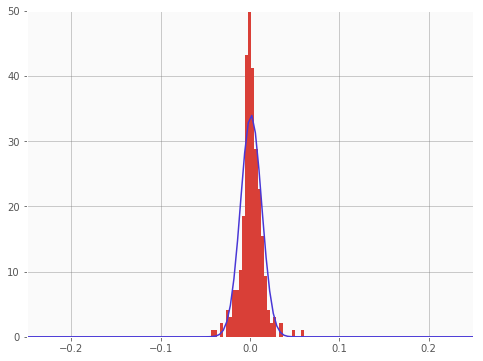

In [59]:
xs = np.linspace(-4,4,2000)

fig, ax = plt.subplots(figsize=(8,6))

ax.hist(np.nan_to_num(pctchgs,0), bins=30, normed=True)
ax.plot(xs, stats.norm.pdf(xs,mu,sig))
ax.set_ylim(0,50)
ax.set_xlim(-.25,.25)
plt.show()

In [86]:
magchgs = np.array(abs((WIKIP2000.History[WIKIP2000.History['Symbol'] == 'AAPL'].DailyPctChg.values)))

In [87]:
magchgs = np.nan_to_num(magchgs)

In [89]:
alpha = est[0]
beta = est[1]
scale = est[-1]

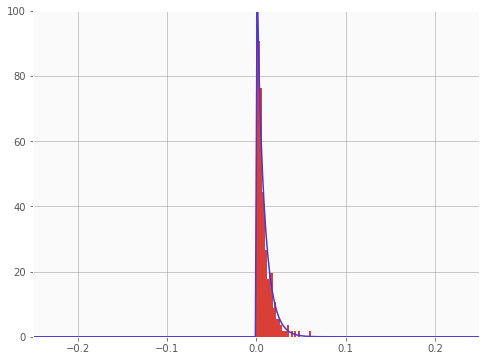

In [90]:
xs = np.linspace(-2,2,2000)

fig, ax = plt.subplots(figsize=(8,6))

ax.hist(magchgs, bins=30, normed=True)
ax.plot(xs, stats.beta.pdf(xs,alpha,beta, scale=scale))
ax.set_ylim(0,100)
ax.set_xlim(-.25,.25)
plt.show()

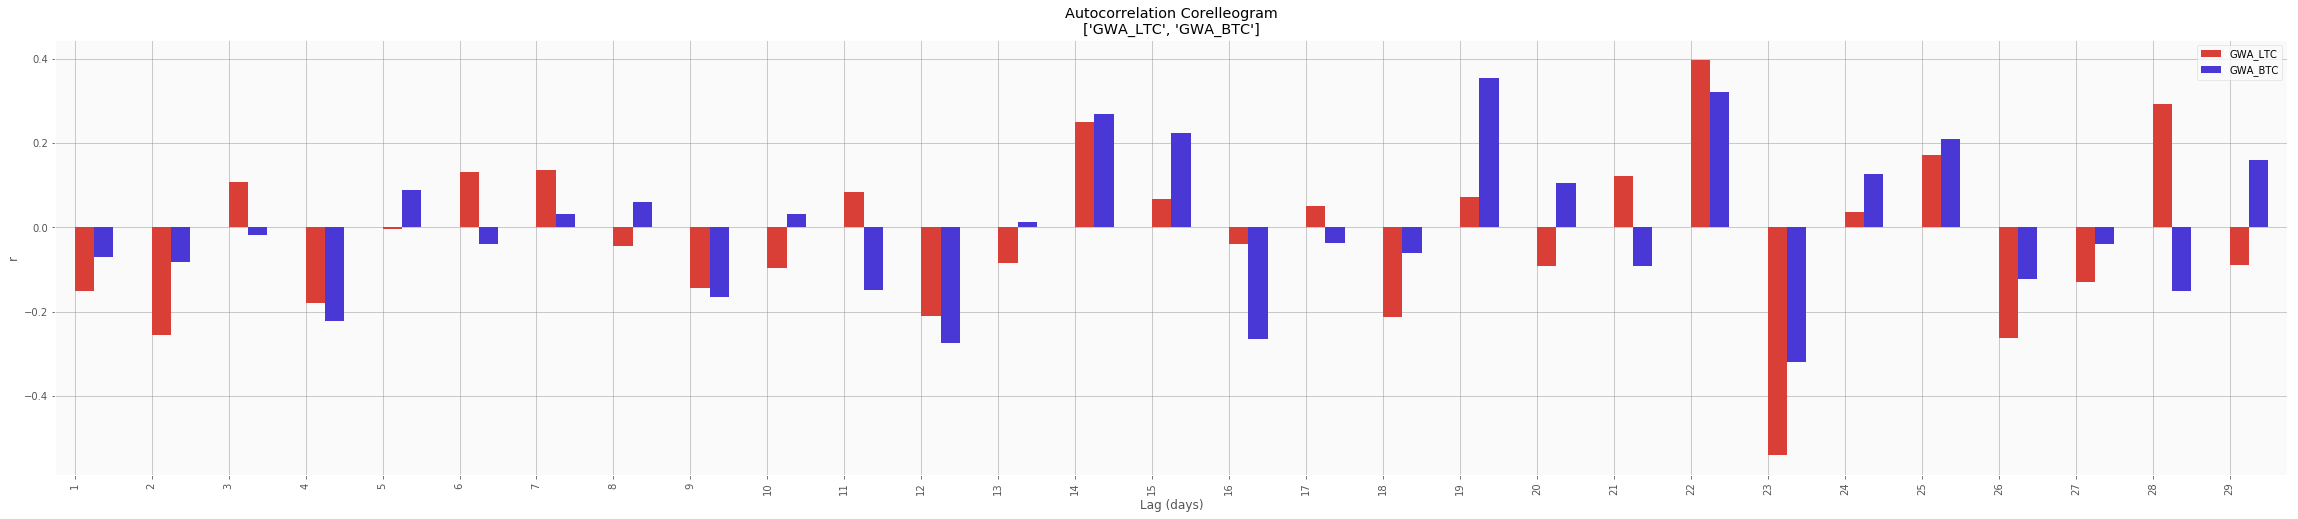

In [72]:
Symbols = ['GWA_LTC','GWA_BTC']

acfs= []
lags = range(1,30)
for sym in Symbols:
    
    sym_pctchg = a.History[a.History['Symbol'] == sym].DailyPctChg
    sym_acf = [sym_pctchg.autocorr(lag = i) for i in lags]
    acfs.append(sym_acf)
    
acf_df = pd.DataFrame(acfs).T
acf_df.columns = Symbols
acf_df.index += 1

ax = acf_df.plot(kind='bar'
            , figsize=(40,8)
            , grid=True
            , position = 0
            , title = 'Autocorrelation Corelleogram\n{}'.format(Symbols)
            )

ax.set_xlabel('Lag (days)')
ax.set_ylabel('r')
plt.show()

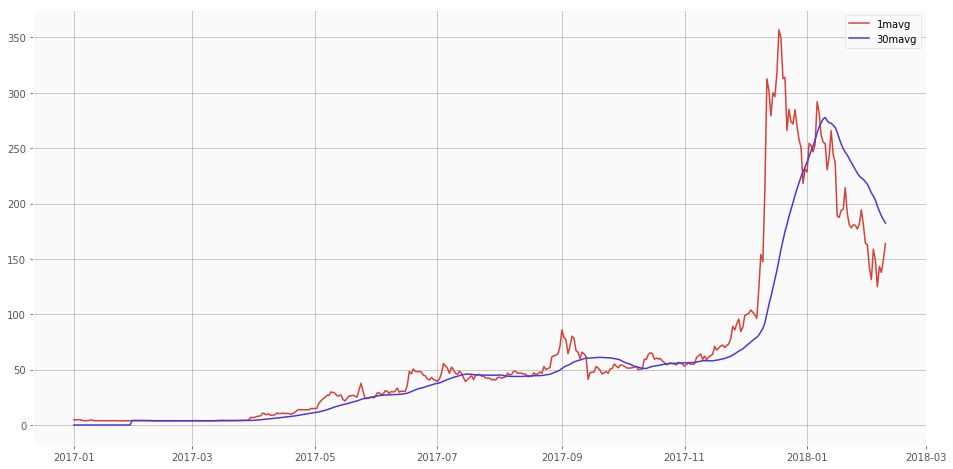

In [122]:
windows = [1,30]
fig, ax = plt.subplots(figsize=(16,8))
dates = a.History['Date'][(a.History['Symbol'] == sym) 
                     &(a.History['Date'] >= '2017-01-01')
                     & (a.History['Date'] <= '2018-02-11')]

for days in windows:
    
    window = str(days) + 'mavg'
    
    mavgs = a.History[a.History['Symbol'] == 'GWA_LTC'].Close.rolling(window=days).mean().fillna(0)
    
    ax.plot(dates, mavgs, label = window)

plt.legend()
plt.show()

In [ ]:
def cacl_mavg(self,
             windows = [5,30]):
    
    symbols = self.History.Symbol.unique()
    windows = windows
    
    mavg_dict =

In [14]:
# potentially tighter the first filter (currently 250)

# Remove all records for symbols that have less than 270 records total (missing data)
excludes = WIKIP2000.History.groupby('Symbol').count()[WIKIP2000.History.groupby('Symbol').count().Description < 270].index.tolist()
WIKIP2000.History = WIKIP2000.History[~WIKIP2000.History.Symbol.isin(excludes)]
print('The following assets were removed from History:\n{}'.format(str(excludes)))

# pivot and unpivot to obtain nulls where data doesn't exist for given symbols
pivot = WIKIP2000.History.pivot(index='Date',columns='Symbol',values='Close').isnull()
pivot = pivot.reset_index()
unpivot = pd.melt(pivot, id_vars = 'Date', value_vars=pivot.columns[1:])

missing_data = unpivot[unpivot.value == True]

subdatas = []

# For each identified missing date/symbol pair in missing_data, identify the most recent previous existing record and
# substitute that value in its place.
for i in range(len(missing_data)):
    breaker = 0
    symbol = missing_data.iloc[i].Symbol
    date = missing_data.iloc[i].Date.to_pydatetime()
    
    if date.weekday() == 0:
        back = 3
    elif date.weekday() == 6:
        back = 2
    else:
        back = 1
    
    prevdate = date + datetime.timedelta(days=-back)

    while WIKIP2000.History[(WIKIP2000.History.Date == prevdate) & (WIKIP2000.History.Symbol == symbol)].shape[0] == 0:
        
        prevdate = prevdate + datetime.timedelta(days=-1)
        
        if prevdate <= min(WIKIP2000.History.Date):
            
            WIKIP2000.History = WIKIP2000.History[~(WIKIP2000.History.Symbol == symbol)]
            breaker = 1
            break
            
    if breaker == 1:
        print('Data Substitution Failed. All {} data removed from History'.format(symbol))
        pass
    else:
        ind = WIKIP2000.History[(WIKIP2000.History.Date == prevdate) & (WIKIP2000.History.Symbol == symbol)].index.values[0]
        subdata = WIKIP2000.History[WIKIP2000.History.index == (ind)].to_dict('records')[0]
        subdata['Date'] = date
        subdata['DailyPctChg'] = 0
        subdatas.append(subdata)

# Lastly, append all the new (substitution) records onto the old History DataFrame, and then reorganize so we're back in order.
WIKIP2000.History = pd.concat([WIKIP2000.History, pd.DataFrame(subdatas)], ignore_index = True)
WIKIP2000.History = WIKIP2000.History.sort_values(by=['Symbol','Date'])
print('{} at {} substituted with data from {}'.format(symbol,date,prevdate))


The following assets were removed from History:
[]
A at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAOI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAON at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAPL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
AAPL at 2017-08-07 00:00:00 substituted with data from 2017-08-04 00:00:00
AAT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ABBV at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ABBV at 2017-11-06 00:00:00 substituted with data from 2017-11-03 00:00:00
ABC at 2017-04-14 00:00:00 substituted with data from 2017

ARNA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARNC at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARQL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARRS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARRY at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARW at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ARWR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ASH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ASNA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ASNA at 2017-08-07 00:00:00 substituted with data from 2017-08-04 00:00:00
AT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ATEN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ATHN at 2017-04-14 00:00:00 su

BV at 2018-02-08 00:00:00 substituted with data from 2018-01-31 00:00:00
BV at 2018-02-09 00:00:00 substituted with data from 2018-01-31 00:00:00
BWA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
BXP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
BXS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
BYD at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
BZH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
C at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CACI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CAG at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CAH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CAKE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CALM at 2017-04-14 00:00:00 substituted w

COUP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CPA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CPB at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CPE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CPN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CPRT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CPT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CREE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CRI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CRIS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CRL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CRM at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CROX at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
CRUS at 2017-04-14 00:00:00 subst

ECL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ECOM at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ECYT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ED at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EDR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EFII at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EFX at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EGHT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EGLT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EGN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EGOV at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EGY at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EIG at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
EIGI at 2017-04-14 00:00:00 subst

FRT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FSS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FTI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FTK at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FTNT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FULT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FVE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
FWRD at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
G at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
GALT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
GCAP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
GD at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
GDOT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
GE at 2017-04-14 00:00:00 substitut

HTLD at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
HTZ at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
HUM at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
HUN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
HURN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
HXL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
HZNP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
I at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
IART at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
IBKR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
IBM at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ICE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ICON at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
ICPT at 2017-04-14 00:00:00 substi

LB at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LBTYA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LDOS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LECO at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LEE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LEG at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LEN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LHO at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LKQ at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LLL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LLNW at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
LLY at 2017-04-14 00:00:00 substitut

MTG at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MTGE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MTOR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MU at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MUSA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MWA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MXIM at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MXL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MYGN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
MYL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
NAT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
NATI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
NAV at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
NAVB at 2017-04-14 00:00:00 subst

PACB at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PACW at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PAG at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PANW at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PAY at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PAYC at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PAYX at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PBCT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PBF at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PBH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PBPB at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PBYI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PCAR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
PCG at 2017-04-14 00:00:00 su

RGC at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RGEN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RGLD at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RGLS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RGS at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RHI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RHP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RHT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RIGL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RJF at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RLGY at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
RLJ at 2017-04-14 00:00:00 substitu

SONC at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPG at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPLK at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPPI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPWH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SPWR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SRCL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SRE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SREV at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SRPT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SSI at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
SSNC at 2017-04-14 00:00:00 su

TTWO at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TUES at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TUP at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TWO at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TWOU at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TWTR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TWX at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TXMD at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TXN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TXRH at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TXT at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TYL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
TZOO at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
UA at 2017-04-14 00:00:00 subst

WTR at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WTW at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WU at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WWE at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WWW at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WY at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WYN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
WYNN at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
X at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
XCRA at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
XEC at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
XEL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
XL at 2017-04-14 00:00:00 substituted with data from 2017-04-13 00:00:00
XLNX at 2017-04-14 00:00:00 substituted w

In [15]:
WIKIP2000f = pd.concat([WIKIP2000.History, pd.DataFrame(subdatas)], ignore_index = True)
WIKIP2000f = WIKIP2000f.sort_values(by=['Symbol','Date'])

In [23]:
datestart = '2018-01-20'
dateend = '2018-02-01'
symbols = WIKIP2000f.Symbol.unique()
windows = [1,2]

mavg_dict = {'Date':WIKIP2000f[(WIKIP2000f['Date'] >= datestart) 
                                      & (WIKIP2000f['Date'] <= dateend)].Date.unique()}

for symbol in symbols:
    
    for window in windows:
        
        label = symbol + '-' + str(window) + 'mavg'
        
        mavg_dict[label] = WIKIP2000f[(WIKIP2000f['Symbol'] == symbol) &
                                     (WIKIP2000f['Date'] >= datestart) 
                                      & (WIKIP2000f['Date'] <= dateend)].Close.rolling(window=window).mean().values
        
mavg_df = pd.DataFrame(mavg_dict)

In [25]:
mavg_df[['Date','CSCO-1mavg','CSCO-2mavg']]

,Date,CSCO-1mavg,CSCO-2mavg
0,2018-01-22,41.66,NaN
1,2018-01-23,42.10,41.880
2,2018-01-24,42.17,42.135
3,2018-01-25,41.90,42.035
4,2018-01-26,42.56,42.230
5,2018-01-29,42.85,42.705
6,2018-01-30,42.25,42.550
7,2018-01-31,41.54,41.895
8,2018-02-01,41.70,41.620


In [4]:
excludes = WIKIP2000.History.groupby('Symbol').count()[WIKIP2000.History.groupby('Symbol').count().Description < 270].index.tolist()

In [15]:
pd.Series(excludes).to_csv('C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_Excludes.csv'
                           , index = False)

In [16]:
a = pd.read_csv('C:/Users/awright/Desktop/January 2018/Other/trading/Market Histories/WIKIP2000_Excludes.csv', header=None)iloc[:,0].values


array(['ABCO', 'ACAS', 'ACAT', 'AF', 'AIRM', 'ALR', 'AMCC', 'AMRI', 'AN',
       'APOL', 'ARIA', 'ATI', 'ATW', 'AVP', 'AWH', 'BBBY', 'BCR', 'BDE',
       'BEAV', 'BHGE', 'BHI', 'BONT', 'BRCD', 'BTU', 'CAB', 'CBR', 'CEB',
       'CEMP', 'CHMT', 'CLMS', 'CLNY', 'CMLS', 'CNX', 'COH', 'COVS', 'CSC',
       'CST', 'CYNO', 'DD', 'DFT', 'DGI', 'DLPH', 'DNB', 'DOW', 'DSCI',
       'DTV', 'DV', 'DWDP', 'DXC', 'ELNK', 'ENH', 'ENOC', 'ENTR', 'EQY',
       'ESV', 'EVER', 'EXAR', 'EXXI', 'FCH', 'FGL', 'FOSL', 'FPO', 'FRED',
       'FSC', 'FSLR', 'FTR', 'FUEL', 'FXCM', 'GALE', 'GCI', 'GDP', 'GIMO',
       'GMAN', 'GNW', 'HAR', 'HCC', 'HLS', 'HSNI', 'HW', 'HWAY', 'IL',
       'INFO', 'INVN', 'IQNT', 'ISIL', 'IXYS', 'JIVE', 'JNS', 'JOY', 'KCG',
       'LIOX', 'LLTC', 'LMCA', 'LMIA', 'LOCK', 'LTM', 'LVLT', 'MEG',
       'MENT', 'MJN', 'MMM', 'MUR', 'MYCC', 'NADL', 'NBR', 'NE', 'NEWS',
       'NMBL', 'NSR', 'OB', 'OGXI', 'OI', 'OSIR', 'PBI', 'PKY', 'PLKI',
       'PLPM', 'PMC', 'PNRA', 'PPG', 'PPHM', 'P

In [6]:
 yello = 'hi'

In [12]:
if yello:
    print('yessir')

In [11]:
yello = None

In [13]:
if oiias:
    print('eh')

NameError: name 'oiias' is not defined

datetime.datetime(2018, 2, 15, 17, 1, 20, 762098)